In [2]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow

%matplotlib inline
import time
import tensorflow as tf
import sys
sys.path.append("../")
import model

In [3]:
def genProposals(image_name):
    s = time.time()
    img = Image.open(image_name)

    h,w = img.size
    base = min(h,w)
    cur_size = 100
    
    props = []
    count = 0
    while cur_size <= base:
        for a in range(0,w,cur_size):
            for b in range(0,h,cur_size):
                crop = img.crop((a,b,a+cur_size,b+cur_size))
                if np.var(np.mean(crop,2)) < 400: continue
                #crop = crop.resize((250,250))
                #crop.save("../data/thumb/%d%d%d.jpg"%(a,b,cur_size))
                
                count += 1
                props.append(((a,b,cur_size),crop))
        cur_size *= 2    
        
    print("Generated %d images"%count)
    print(time.time()-s)
    return props

In [4]:
props = genProposals('../data/small.jpeg')

Generated 647 images
6.634881258010864


In [9]:
tf.reset_default_graph()
model_path = "../models/small/model.ckpt"

X = tf.placeholder(tf.float32, [None, 32,32])
Y = tf.placeholder(tf.float32, [None,2])
optimizer,cost,acc,prob = model.small_model(X,Y)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, model_path)
    X_all = []
    for region,img in props:
        img_res = np.asarray(img.resize((32,32)).convert('1'))
        X_all.append(img_res)
        
    probs_ = sess.run([prob], feed_dict={X:X_all,Y:np.zeros((len(X_all),2))})
    probs = probs_[0]

INFO:tensorflow:Restoring parameters from ../models/small/model.ckpt


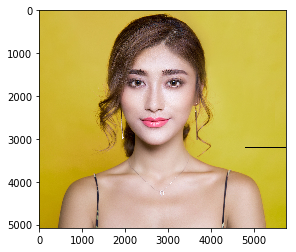

In [10]:
max_face = max([i for i in range(len(probs)) if probs[i][0] > probs[i][1]])

img = Image.open('../data/small.jpeg').convert("RGBA")
draw = ImageDraw.Draw(img)
a,b,size = props[max_face][0]

draw.rectangle([(a,b),(a+size,b+size)],outline=(0,0,0,255))

img.save("../data/rect.jpg")
imshow(img)